# **Data-Driven Customer Segmentation and Churn Analysis**
This project performs a **comprehensive customer segmentation and churn analysis using RFM (Recency, Frequency, Monetary) data.** The goal was to identify distinct customer groups and predict their likelihood of "churning," or leaving the business.

**Key Findings:**

**RFM Segmentation:** Customers were successfully divided into meaningful segments like "Champions," "Loyal Customers," and "At-Risk" groups based on their spending behavior.

**Churn Prediction:** An XGBoost machine learning model was built to predict customer churn. The model demonstrated that Monetary value (how much a customer spends) is the most significant factor in predicting whether they will leave, followed by Recency and then Frequency.

**Actionable Insights**: The analysis provides a clear roadmap for targeted marketing. For example, "Champions" should be engaged with loyalty programs, while "At-Risk" customers can be targeted with win-back campaigns.

**Overall, this project provides a solid framework for understanding customer behavior and proactively reducing churn, which is a critical goal for any business.**

**Data Loading**

In [ ]:
import pandas as pd

file_path = "online_retail_II.xlsx"

df1 = pd.read_excel(file_path, sheet_name="Year 2009-2010")
df2 = pd.read_excel(file_path, sheet_name="Year 2010-2011")

df = pd.concat([df1, df2])

print(df.shape)
print(df.head())

(1067371, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


**Data Cleaning & Feature Engineering**

In [ ]:
import pandas as pd

df = df.dropna(subset=["Customer ID"])

df = df[df["Quantity"] > 0]

df["TotalPrice"] = df["Quantity"] * df["Price"]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

**RFM Segmentation**

RFM = Recency, Frequency, Monetary

In [ ]:
import datetime as dt

ref_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,  # Recency
    "Invoice": "nunique",                               # Frequency
    "TotalPrice": "sum"                                 # Monetary
})

rfm.rename(columns={"InvoiceDate": "Recency",
                    "Invoice": "Frequency",
                    "TotalPrice": "Monetary"}, inplace=True)

print(rfm.head())

             Recency  Frequency  Monetary
Customer ID                              
12346.0          326         12  77556.46
12347.0            2          8   5633.32
12348.0           75          5   2019.40
12349.0           19          4   4428.69
12350.0          310          1    334.40


**Churn Labeling**

In [ ]:
rfm["Churned"] = (rfm["Recency"] > 90).astype(int)

print(rfm["Churned"].value_counts())

Churned
1    2991
0    2890
Name: count, dtype: int64


**Churn Prediction (XGBoost)**





In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = rfm[["Recency", "Frequency", "Monetary"]]
y = rfm["Churned"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       879
           1       1.00      1.00      1.00       886

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:05:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**RFM Distributions**

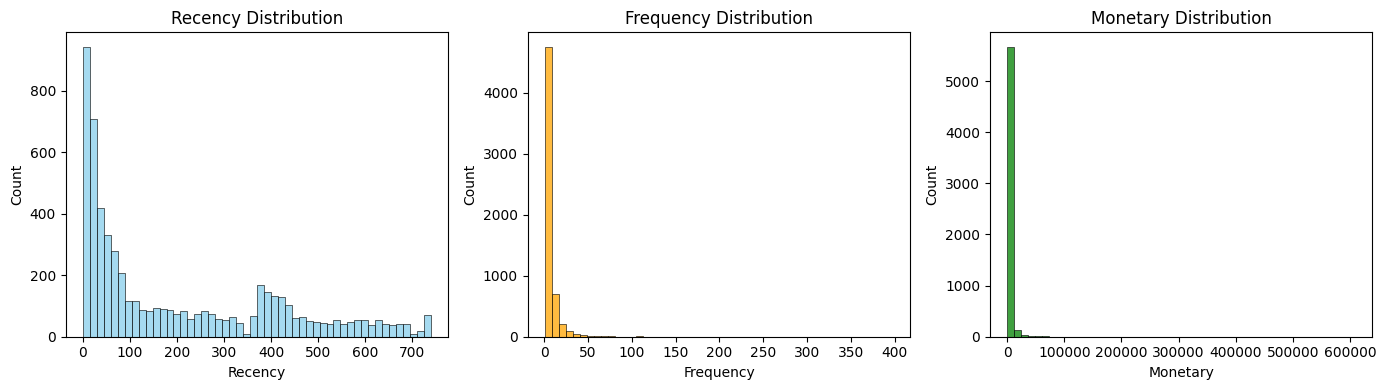

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.histplot(rfm["Recency"], bins=50, kde=False, color="skyblue")
plt.title("Recency Distribution")

plt.subplot(1,3,2)
sns.histplot(rfm["Frequency"], bins=50, kde=False, color="orange")
plt.title("Frequency Distribution")

plt.subplot(1,3,3)
sns.histplot(rfm["Monetary"], bins=50, kde=False, color="green")
plt.title("Monetary Distribution")

plt.tight_layout()
plt.show()

**Churn Prediction**

/tmp/ipython-input-3249169979.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churned", data=rfm, palette="Set2")


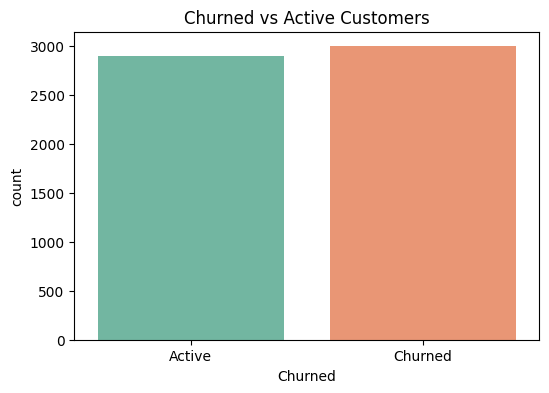

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churned", data=rfm, palette="Set2")
plt.title("Churned vs Active Customers")
plt.xticks([0,1], ["Active", "Churned"])
plt.show()

**RFM Heatmap Segmentation**

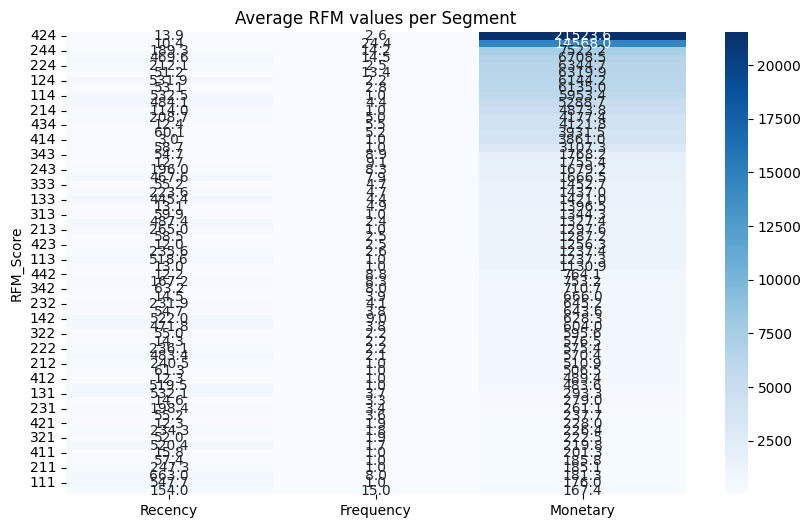

In [ ]:
rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4, labels=[1,2,3,4])
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R_quartile'].astype(str) + rfm['F_quartile'].astype(str) + rfm['M_quartile'].astype(str)

rfm_summary = rfm.groupby("RFM_Score").agg({
    "Recency":"mean","Frequency":"mean","Monetary":"mean","Churned":"mean"
}).sort_values("Monetary", ascending=False)

plt.figure(figsize=(10,6))
sns.heatmap(rfm_summary[["Recency","Frequency","Monetary"]], annot=True, fmt=".1f", cmap="Blues")
plt.title("Average RFM values per Segment")
plt.show()

In [ ]:
print(rfm.columns)

Index(['Recency', 'Frequency', 'Monetary', 'Churned', 'R_quartile',
       'F_quartile', 'M_quartile', 'RFM_Score', 'RFM_Segment', 'Segment',
       'Churn_Prob'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate

rfm['RFM_Segment'] = rfm['R_quartile'].astype(str) + rfm['F_quartile'].astype(str) + rfm['M_quartile'].astype(str)
rfm['RFM_Score'] = rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

def segment_me(row):
    """Assigns a customer segment based on RFM quartiles."""
    if row['R_quartile'] == 4 and row['F_quartile'] == 4 and row['M_quartile'] == 4:
        return 'Champions'
    elif row['R_quartile'] >= 3 and row['F_quartile'] >= 3:
        return 'Loyal Customers'
    elif row['R_quartile'] == 4 and row['F_quartile'] <= 2:
        return 'Potential Loyalist'
    elif row['R_quartile'] == 4:
        return 'New Customers'
    elif row['F_quartile'] == 4:
        return 'Big Spenders'
    elif row['R_quartile'] <= 2 and row['F_quartile'] <= 2 and row['M_quartile'] <= 2:
        return 'At Risk'
    elif row['R_quartile'] == 1:
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_me, axis=1)

segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

segment_summary['CustomerCount'] = rfm['Segment'].value_counts().reindex(segment_summary['Segment']).values

segment_descriptions = {
    "Champions": "Recent buyers, frequent purchases, and highest spenders. Keep them engaged with rewards, loyalty programs, and special offers.",
    "Loyal Customers": "They buy often and spend well. Build long-term relationships through exclusive benefits and personalized recommendations.",
    "Potential Loyalist": "New but promising customers. Encourage repeat purchases with discounts or onboarding offers.",
    "New Customers": "Very recent buyers. Provide great first experiences to convert them into loyal customers.",
    "Big Spenders": "Spend a lot but may not be recent or frequent. Upsell, cross-sell, and give premium offers.",
    "At Risk": "Haven’t purchased in a while, low frequency and spend. Win them back with reactivation campaigns.",
    "Lost Customers": "Inactive and low-value customers. Decide whether to re-engage or stop targeting.",
    "Others": "Customers who don’t fit well into a single category. Monitor and analyze further."
}

segment_summary['Description'] = segment_summary['Segment'].map(segment_descriptions)

headers = ['Segment', 'Customer Count', 'Avg. Recency', 'Avg. Frequency', 'Avg. Monetary', 'Description']

table_data = segment_summary[['Segment','CustomerCount','Recency','Frequency','Monetary','Description']].values.tolist()

for row in table_data:
    row[2] = f"{row[2]:.2f}"
    row[3] = f"{row[3]:.2f}"
    row[4] = f"{row[4]:.2f}"

print("\n📊 Customer Segmentation Summary:\n")
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


📊 Customer Segmentation Summary:

╒════════════════════╤══════════════════╤════════════════╤══════════════════╤═════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Segment            │   Customer Count │   Avg. Recency │   Avg. Frequency │   Avg. Monetary │ Description                                                                                                                    │
╞════════════════════╪══════════════════╪════════════════╪══════════════════╪═════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ At Risk            │             1776 │         419.28 │             1.39 │          324.2  │ Haven’t purchased in a while, low frequency and spend. Win them back with reactivation campaigns.                              │
├────────────────────┼──────────────────┼────────────────┼───────

**Feature Importance (from XGBoost)**

<Figure size 800x600 with 0 Axes>

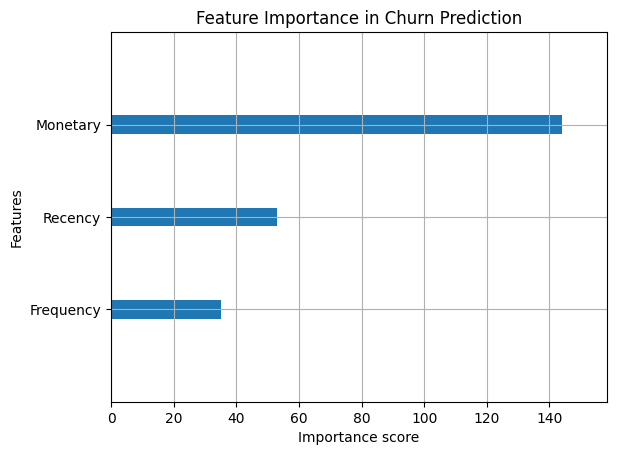

In [ ]:
from xgboost import plot_importance

plt.figure(figsize=(8,6))
plot_importance(model, importance_type="weight", show_values=False)
plt.title("Feature Importance in Churn Prediction")
plt.show()

**Probability Distribution of Churn**

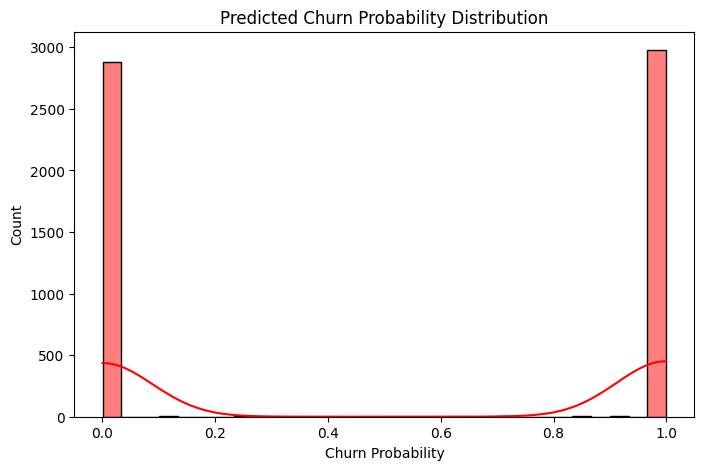

In [ ]:
import numpy as np

rfm["Churn_Prob"] = model.predict_proba(X)[:,1]

plt.figure(figsize=(8,5))
sns.histplot(rfm["Churn_Prob"], bins=30, kde=True, color="red")
plt.title("Predicted Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.show()